In [1]:
import scipy.io
import scipy.stats
import matplotlib.pyplot as plt
import re
import os
from IPython.display import Image 
import cv2
from tempfile import TemporaryFile
from scipy import stats
from torchvision import transforms
import pandas as pd
import shutil
import datetime
import glob
from scipy import integrate
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from PIL import ImageFile, Image
import sys
sys.path.insert(1, '../architecture')
sys.path.insert(2, '../dataLoaders')
from ProUNet import *
import torchvision.models as models
from MapillaryDataLoader import *
from VolvoDataLoader import *
from tqdm import tqdm
from torchsummary import summary
from matplotlib.patches import Rectangle
from collections import OrderedDict
from reliability_diagrams import *

import numpy as np
import cv2 as cv
#from MapRSCD import *
%matplotlib inline

2024-06-01 12:20:58.712735: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [15]:
def genrateSumm(oneClass = -1, modelName  = "EmphasizeOnKL"):
    
    
    args = {
    "mode":"val",
    "input_img_dim":(256,256),
    "mapillaryRootPath":'../../../datasets/augmented_mapillary',
    "cityscapesRootPath":'../../../datasets/augmented_cityscapes',
    "RSCDRootPath":'../../../datasets/RSCD',
    "volvoRootPath":"../../../datasets/augmented_volvo",
    "reducedCategories":True
    }

    dataloader = volvoDataLoader(**args)
    
    device = torch.device('cuda:1')
    model = ProUNet(gecoConfig = {"enable":False}, device = device, num_classes = dataloader.get_num_classes(), LatentVarSize = 6, beta = 3, training = True, num_samples = 16).to(device)
    check = torch.load("../checkpoints/HVAEFri_{}/best.pth".format(modelName), map_location=device)
    model.load_state_dict(check['model_state_dict'])
    val_loader = DataLoader(dataset = dataloader, batch_size = 50, shuffle = True, drop_last = True)
    
    summaries = {}
    for i,batch in enumerate(val_loader):

        segs, dists, samplesFri = model.inference(batch["image"].to(device))

        if oneClass>-1:
            y_pred = torch.where(torch.argmax(torch.mean(segs, 0), axis = 1) == oneClass, 1, 0).cpu().detach().numpy()
            y_true = torch.where(torch.argmax(batch["label"], axis = 1) == oneClass, 1, 0).cpu().detach().numpy()
            confidence = torch.where(torch.argmax(torch.mean(segs, 0), axis = 1) == oneClass,
                                     torch.max(torch.mean(segs, 0), axis=1)[0], 0).cpu().detach().numpy()
        else:
            y_pred = torch.argmax(torch.mean(segs, 0), axis = 1).cpu().detach().numpy()
            y_true = torch.argmax(batch["label"], axis=1).cpu().detach().numpy()
            confidence = torch.max(torch.mean(segs, 0), axis=1)[0].cpu().detach().numpy()

        batchSumm = compute_calibration(y_true.flatten(), y_pred.flatten(), confidence.flatten(), num_bins = 10)

        if len(summaries.keys())<1:
            summaries = batchSumm
        else:
            for items in batchSumm.items():
                if items[0] != "bins":
                    summaries[items[0]] += items[1]


    for items in summaries.items():
        if items[0] not in ["bins", "counts"]:
            summaries[items[0]] = items[1]/(len(val_loader)-1)

    return summaries

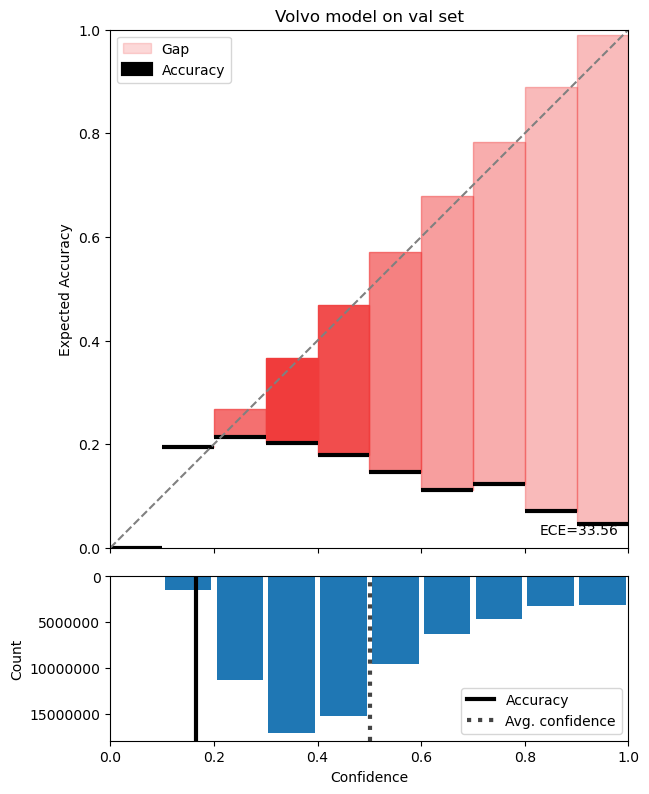

In [18]:
fig = reliability_diagram_combined(genrateSumm(modelName = "volvo_onTheFly_crf3"), 
                              draw_ece=True, draw_bin_importance="alpha", draw_averages=True, 
                              title="Volvo model on val set", figsize=(6, 6), dpi=100, return_fig=True)

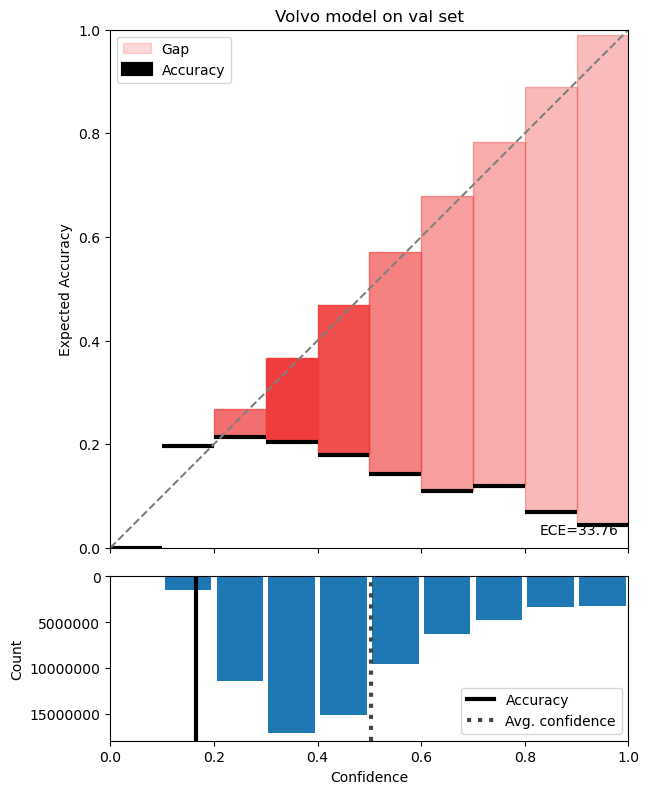

In [10]:
fig = reliability_diagram_combined(genrateSumm(modelName = "volvo_onTheFly_crf2"), 
                              draw_ece=True, draw_bin_importance="alpha", draw_averages=True, 
                              title="Volvo model on val set", figsize=(6, 6), dpi=100, return_fig=True)

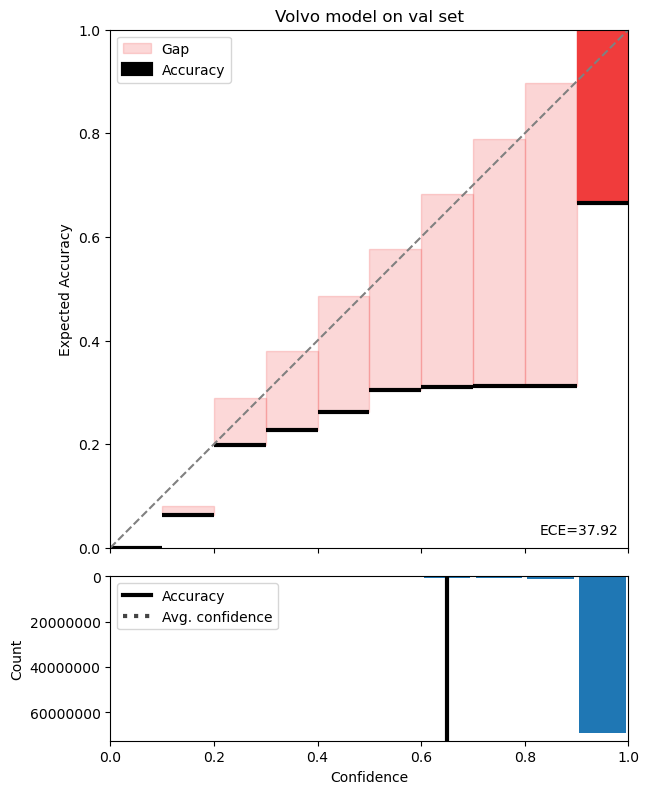

In [11]:
fig = reliability_diagram_combined(genrateSumm(modelName = "volvo_onTheFly_crf"), 
                              draw_ece=True, draw_bin_importance="alpha", draw_averages=True, 
                              title="Volvo model on val set", figsize=(6, 6), dpi=100, return_fig=True)

In [6]:
# fig = reliability_diagram_combined(genrateSumm(modelName = "EmphasizeOnKL"), 
#                               draw_ece=True, draw_bin_importance="alpha", draw_averages=True, 
#                               title="KL-emphasize model on val set", figsize=(6, 6), dpi=100, return_fig=True)

In [7]:
# fig = reliability_diagram_combined(genrateSumm(modelName = "EmphasizeOnKL", oneClass = 4), 
#                               draw_ece=True, draw_bin_importance="alpha", draw_averages=True, 
#                               title="KL-emphasize model on val set ice category", figsize=(6, 6), dpi=100, return_fig=True)

In [8]:
# fig = reliability_diagram_combined(genrateSumm(modelName = "EmphasizeOnKL", oneClass = 3), 
#                           draw_ece=True, draw_bin_importance="alpha", draw_averages=True, 
#                           title="KL-emphasize model on val set snow category", figsize=(6, 6), dpi=100, return_fig=True)